# <center> Kaggle Competition : Estimate CO2 emissions from cars <center>
## <center> Cécile Huang & Alice Liu <center>

## Columns
• ID - Identification number<br>
• MS - Member state<br>
• Mp - Manufacturer pooling<br>
• VFN - Vehicle family identification number<br>
• Mh -Manufacturer name<br>
EU standard denomination<br>
• Man - Manufacturer name OEM declaration<br>
• MMS - Manufacturer name MS registry denomination<br>
• TAN - Type approval number<br>
• T - Type<br>
• Va - Variant<br>
• Ve - Version<br>
• Mk - Make<br>
• Cn - Commercial name<br>
• Ct - Category of the vehicle type approved<br>
• Cr - Category of the vehicle registered<br>
• m (kg) - Mass in running order Completed/complete vehicle<br>
• Mt - WLTP test mass<br>
• Enedc (g/km) - Specific CO2 Emissions (NEDC)<br>
• Ewltp (g/km) - Specific CO2 Emissions (WLTP)<br>
• W (mm) - Wheel Base<br>
• At1 (mm) - Axle width steering axle<br>
• At2 (mm) - Axle width other axle<br>
• Ft - Fuel type<br>
• Fm - Fuel mode<br>
• ec (cm3) - Engine capacity<br>
• ep (KW) - Engine power<br>
• z (Wh/km) - Electric energy consumption<br>
• IT - Innovative technology or group of innovative technologies<br>
• Ernedc (g/km) - Emissions reduction through innovative technologies<br>
• Erwltp (g/km) - Emissions reduction through innovative technologies (WLTP)<br>
• De - Deviation factor<br>
• Vf - Verification factor<br>
• r - Total new registrations<br>

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')

from src import preprocessing as prepro
from src import modele

from category_encoders import CatBoostEncoder, LeaveOneOutEncoder, TargetEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Set, Tuple
from scipy.stats import shapiro
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import warnings
import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importation de la donnée

In [2]:
df_train = pd.read_csv('..\\data\\train.csv',sep=',')

df_test = pd.read_csv('..\\data\\test.csv',sep=',')

In [3]:
print(f'df_train : il y a {df_train.shape[1]} colonnes et {df_train.shape[0]} observations')
print(f'df_test : il y a {df_test.shape[1]} colonnes et {df_test.shape[0]} observations')

df_train : il y a 37 colonnes et 7571649 observations
df_test : il y a 36 colonnes et 1892913 observations


In [4]:
df_train.head()

,ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,Date of registration,Fuel consumption,Electric range (km)
0,0,DE,IP-C519_2022_00008-WF0-1,FORD,FORD WERKE GMBH,FORD WERKE GMBH,NaN,e13*2007/46*1911*15,DEH,R0DB1NX,5BSCENA5JBS,FORD,FOCUS,M1,M1,1,1387.0,1534.0,NaN,401.053306,2700.0,1571.0,1576.0,PETROL,H,999.0,92.0,NaN,e13 32 37,NaN,2.30,NaN,NaN,P,2022-08-29,5.6,NaN
1,1,FR,IP-MQB27ZZ_A2_0529-WVW-1,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN AG,NaN,e1*2007/46*1783*29,AW,ABDLAC,FM5FM5DF008N3VR24BI1CA0I,VOLKSWAGEN,POLO,M1,M1,1,1172.0,1337.0,NaN,394.684459,2552.0,1500.0,1483.0,PETROL,M,999.0,70.0,NaN,e1 29,NaN,1.14,NaN,NaN,P,2022-02-22,5.5,NaN
2,2,FR,IP-MQB27ZZ_A1_0533-WVW-1,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN AG,NaN,e1*2007/46*1783*29,AW,ABDLAC,FD7FD7CW005N2VR24BI1AA0I,VOLKSWAGEN,POLO,M1,M1,1,1204.0,1335.0,NaN,398.561951,2552.0,1500.0,1483.0,PETROL,M,999.0,70.0,NaN,e1 29,NaN,1.14,NaN,NaN,P,2022-03-26,5.6,NaN
3,3,DE,IP-04-U5Y-2018-1137,KIA,KIA SLOVAKIA,KIA SLOVAKIA SRO,NaN,e4*2007/46*1299*18,CD,BAP71,D73F12,KIA,PROCEED,M1,M1,1,1438.0,1588.0,NaN,479.470056,2650.0,1555.0,1563.0,PETROL,M,1591.0,150.0,NaN,e4 28,NaN,0.80,NaN,NaN,P,2022-09-01,6.8,NaN
4,4,FR,IP-MQB27ZZ_B2_0534-WVW-1,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN AG,NaN,e1*2007/46*1783*29,AW,ABDLAA,FD7FD7CW005N2VR24BI1CB0I,VOLKSWAGEN,POLO,M1,M1,1,1207.0,1350.0,NaN,421.854820,2552.0,1500.0,1483.0,PETROL,M,999.0,81.0,NaN,e1 29,NaN,1.14,NaN,NaN,P,2022-01-21,5.9,NaN


In [5]:
df_test.head()

,ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,Date of registration,Fuel consumption,Electric range (km)
0,8000000,FR,IP-DGY____EAT82552-VR3-0,STELLANTIS,PSA,PSA AUTOMOBILES SA,NaN,e9*2018/858*11066*03,N,D,DGYP-A1C000,CITROEN,C5 X,M1,M1,1,1797.0,1888.0,30.0,2785.0,1600.0,1605.0,PETROL/ELECTRIC,P,1598.0,132.0,159.0,NaN,NaN,NaN,NaN,NaN,P,2022-12-30,1.3,59.0
1,8000001,IE,NaN,HYUNDAI MOTOR EUROPE,HYUNDAI ASSAN,HYUNDAI ASSAN OTOMOTIV SANAYI VE TICARET AS,NaN,e5*2007/46*0121*01,BC3,B5P51,D71CZ2,HYUNDAI,i20,M1,M1,1,1165.0,1297.0,NaN,2580.0,1531.0,1536.0,PETROL,M,998.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2022-02-07,4.7,NaN
2,8000002,IE,NaN,HYUNDAI MOTOR EUROPE,HYUNDAI ASSAN,HYUNDAI ASSAN OTOMOTIV SANAYI VE TICARET AS,NaN,e5*2007/46*0121*01,BC3,B5P51,D71CZ2,HYUNDAI,i20,M1,M1,1,1165.0,1297.0,NaN,2580.0,1531.0,1536.0,PETROL,M,998.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2022-03-23,4.7,NaN
3,8000003,IE,NaN,HYUNDAI MOTOR EUROPE,HYUNDAI ASSAN,HYUNDAI ASSAN OTOMOTIV SANAYI VE TICARET AS,NaN,e5*2007/46*0121*01,BC3,B5P51,D71CZ2,HYUNDAI,i20,M1,M1,1,1165.0,1297.0,NaN,2580.0,1531.0,1536.0,PETROL,M,998.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2022-02-03,4.7,NaN
4,8000004,IE,NaN,HYUNDAI MOTOR EUROPE,HYUNDAI ASSAN,HYUNDAI ASSAN OTOMOTIV SANAYI VE TICARET AS,NaN,e5*2007/46*0121*01,BC3,B5P51,D71CZ2,HYUNDAI,i20,M1,M1,1,1165.0,1297.0,NaN,2580.0,1531.0,1536.0,PETROL,M,998.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2022-01-26,4.7,NaN


In [6]:
df_train.describe()

,ID,MMS,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),ec (cm3),ep (KW),z (Wh/km),Ernedc (g/km),Erwltp (g/km),De,Vf,Fuel consumption,Electric range (km)
count,7.571649e+06,0.0,7571649.0,7.571549e+06,6.731413e+06,1.223639e+06,7.571649e+06,7.559361e+06,7.405964e+06,7.394351e+06,6.548884e+06,7.552462e+06,1.667320e+06,0.0,4.052504e+06,0.0,0.0,5.791788e+06,1.290402e+06
mean,3.785824e+06,NaN,1.0,1.528211e+03,1.649902e+03,5.837474e+00,3.402771e+02,2.670402e+03,1.553381e+03,1.555456e+03,1.543329e+03,1.094335e+02,1.719866e+02,NaN,1.520159e+00,NaN,NaN,5.288046e+00,2.506859e+02
std,2.185747e+06,NaN,0.0,3.526125e+02,3.638574e+02,1.341793e+01,1.830414e+02,1.679752e+02,5.930780e+01,6.350400e+01,5.168066e+02,5.696133e+01,3.144126e+01,NaN,4.912715e-01,NaN,NaN,1.768103e+00,1.877607e+02
min,0.000000e+00,NaN,1.0,5.700000e+02,6.110000e+02,0.000000e+00,-1.530574e+01,6.000000e+02,5.200000e+02,5.200000e+02,4.000000e+00,5.000000e+00,1.000000e+01,NaN,5.000000e-01,NaN,NaN,5.000000e-01,1.300000e+01
25%,1.892912e+06,NaN,1.0,1.263000e+03,1.381000e+03,0.000000e+00,3.176032e+02,2.570000e+03,1.520000e+03,1.520000e+03,1.197000e+03,7.400000e+01,1.540000e+02,NaN,1.100000e+00,NaN,NaN,4.700000e+00,6.200000e+01
50%,3.785824e+06,NaN,1.0,1.457000e+03,1.582000e+03,0.000000e+00,3.866023e+02,2.667000e+03,1.559000e+03,1.558000e+03,1.498000e+03,9.600000e+01,1.650000e+02,NaN,1.680000e+00,NaN,NaN,5.400000e+00,2.300000e+02
75%,5.678736e+06,NaN,1.0,1.737000e+03,1.867000e+03,0.000000e+00,4.382117e+02,2.730000e+03,1.590000e+03,1.595000e+03,1.968000e+03,1.280000e+02,1.830000e+02,NaN,1.960000e+00,NaN,NaN,6.000000e+00,4.310000e+02
max,7.571648e+06,NaN,1.0,4.427000e+03,4.711000e+03,4.900000e+01,2.200959e+03,5.234000e+03,3.000000e+03,3.000000e+03,7.993000e+03,1.177000e+03,9.990000e+02,NaN,6.000000e+00,NaN,NaN,2.800000e+01,8.430000e+02


In [7]:
df_test.describe()

,ID,MMS,r,m (kg),Mt,Enedc (g/km),W (mm),At1 (mm),At2 (mm),ec (cm3),ep (KW),z (Wh/km),Ernedc (g/km),Erwltp (g/km),De,Vf,Fuel consumption,Electric range (km)
count,1.892913e+06,0.0,1892913.0,1.892892e+06,1.682543e+06,305061.000000,1.889749e+06,1.851846e+06,1.848930e+06,1.637929e+06,1.888121e+06,415807.000000,0.0,1.014387e+06,0.0,0.0,1.448269e+06,321937.000000
mean,8.946456e+06,NaN,1.0,1.527802e+03,1.649430e+03,5.847526,2.670276e+03,1.553302e+03,1.555372e+03,1.542825e+03,1.093781e+02,172.043547,NaN,1.519572e+00,NaN,NaN,5.287185e+00,251.006958
std,5.464371e+05,NaN,0.0,3.527714e+02,3.638399e+02,13.442405,1.682445e+02,5.926031e+01,6.344802e+01,5.160861e+02,5.698986e+01,31.504740,NaN,4.913965e-01,NaN,NaN,1.764690e+00,187.828691
min,8.000000e+06,NaN,1.0,5.700000e+02,6.160000e+02,0.000000,9.540000e+02,6.000000e+02,6.000000e+02,5.000000e+01,5.000000e+00,10.000000,NaN,5.000000e-01,NaN,NaN,5.000000e-01,13.000000
25%,8.473228e+06,NaN,1.0,1.263000e+03,1.381000e+03,0.000000,2.570000e+03,1.520000e+03,1.520000e+03,1.197000e+03,7.400000e+01,154.000000,NaN,1.100000e+00,NaN,NaN,4.700000e+00,62.000000
50%,8.946456e+06,NaN,1.0,1.455000e+03,1.581000e+03,0.000000,2.667000e+03,1.559000e+03,1.558000e+03,1.498000e+03,9.600000e+01,165.000000,NaN,1.680000e+00,NaN,NaN,5.400000e+00,230.000000
75%,9.419684e+06,NaN,1.0,1.735000e+03,1.865000e+03,0.000000,2.730000e+03,1.590000e+03,1.594000e+03,1.968000e+03,1.280000e+02,183.000000,NaN,1.960000e+00,NaN,NaN,6.000000e+00,431.000000
max,9.892912e+06,NaN,1.0,4.525000e+03,4.574000e+03,49.000000,4.500000e+03,2.995000e+03,2.995000e+03,7.993000e+03,1.103000e+03,512.000000,NaN,5.100000e+00,NaN,NaN,2.519000e+01,843.000000


# Pré-processing

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7571649 entries, 0 to 7571648
Data columns (total 37 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Country               object 
 2   VFN                   object 
 3   Mp                    object 
 4   Mh                    object 
 5   Man                   object 
 6   MMS                   float64
 7   Tan                   object 
 8   T                     object 
 9   Va                    object 
 10  Ve                    object 
 11  Mk                    object 
 12  Cn                    object 
 13  Ct                    object 
 14  Cr                    object 
 15  r                     int64  
 16  m (kg)                float64
 17  Mt                    float64
 18  Enedc (g/km)          float64
 19  Ewltp (g/km)          float64
 20  W (mm)                float64
 21  At1 (mm)              float64
 22  At2 (mm)              float64
 23  Ft     

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892913 entries, 0 to 1892912
Data columns (total 36 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Country               object 
 2   VFN                   object 
 3   Mp                    object 
 4   Mh                    object 
 5   Man                   object 
 6   MMS                   float64
 7   Tan                   object 
 8   T                     object 
 9   Va                    object 
 10  Ve                    object 
 11  Mk                    object 
 12  Cn                    object 
 13  Ct                    object 
 14  Cr                    object 
 15  r                     int64  
 16  m (kg)                float64
 17  Mt                    float64
 18  Enedc (g/km)          float64
 19  W (mm)                float64
 20  At1 (mm)              float64
 21  At2 (mm)              float64
 22  Ft                    object 
 23  Fm     

## Traitement des valeurs manquantes

Cas spécifique : nous avons remarqué que z (Wh/km) et Electric Range avaient beaucoup de valeurs manquantes donc on a analysé dans les détails du pourquoi.

In [10]:
# afficher % de valeurs manquantes sur les z (Electric energy consumption)

taux_NaN_z_elec_hybrid = df_train[df_train['Ft'].isin(['ELECTRIC', 'PETROL/ELECTRIC', 'DIESEL/ELECTRIC'])]['z (Wh/km)'].isna().mean()
taux_NaN_z_non_elec_hybrid = df_train[~df_train['Ft'].isin(['ELECTRIC', 'PETROL/ELECTRIC', 'DIESEL/ELECTRIC'])]['z (Wh/km)'].isna().mean()

taux_NaN_electricrange_elec_hybrid = df_train[df_train['Ft'].isin(['ELECTRIC', 'PETROL/ELECTRIC', 'DIESEL/ELECTRIC'])]['Electric range (km)'].isna().mean()
taux_NaN_electricrange_non_elec_hybrid = df_train[~df_train['Ft'].isin(['ELECTRIC', 'PETROL/ELECTRIC', 'DIESEL/ELECTRIC'])]['Electric range (km)'].isna().mean()

print(f"""
      Taux de valeurs manquantes pour z (Wh/km) sur les voitures électriques/hybrides : {taux_NaN_z_elec_hybrid * 100:.2f}%
      Taux de valeurs manquantes pour z (Wh/km) sur les voitures non électriques/hybrides : {taux_NaN_z_non_elec_hybrid * 100:.2f}%
      
      Taux de valeurs manquantes pour Electric Range sur les voitures électriques/hybrides : {taux_NaN_electricrange_elec_hybrid * 100:.2f}%
      Taux de valeurs manquantes pour Electric Range sur les voitures non électriques/hybrides : {taux_NaN_electricrange_non_elec_hybrid * 100:.2f}%
      """)



      Taux de valeurs manquantes pour z (Wh/km) sur les voitures électriques/hybrides : 4.09%
      Taux de valeurs manquantes pour z (Wh/km) sur les voitures non électriques/hybrides : 99.98%
      
      Taux de valeurs manquantes pour Electric Range sur les voitures électriques/hybrides : 25.73%
      Taux de valeurs manquantes pour Electric Range sur les voitures non électriques/hybrides : 100.00%
      


Au final les NaN étaient à cause des voitures qui n'étaient pas électriques ou hybrides donc on les a imputées à la main par 0. C'est normal car ces deux variables sont liées aux voitures électriques.

In [11]:
# Traitement spécifique pour z et electric range

# type de voitures électriques
carburant_electrique = ['ELECTRIC','PETROL/ELECTRIC','DIESEL/ELECTRIC ']

# imputation de la variable z
df_train['z (Wh/km)'] = df_train.apply(lambda row: 0 if row['Ft'] not in carburant_electrique else row['z (Wh/km)'], axis=1)
df_train['z (Wh/km)'].fillna(df_train[df_train['Ft'].isin(carburant_electrique)]['z (Wh/km)'].mean(), inplace=True)
df_test['z (Wh/km)'] = df_test.apply(lambda row: 0 if row['Ft'] not in carburant_electrique else row['z (Wh/km)'], axis=1)
df_test['z (Wh/km)'].fillna(df_test[df_test['Ft'].isin(carburant_electrique)]['z (Wh/km)'].mean(), inplace=True)

#imputation de la variable Electric range (km)
df_train['Electric range (km)'] = df_train.apply(lambda row: 0 if row['Ft'] not in carburant_electrique else row['Electric range (km)'], axis=1)
df_train['Electric range (km)'].fillna(df_train[df_train['Ft'].isin(carburant_electrique)]['Electric range (km)'].mean(), inplace=True)
df_test['Electric range (km)'] = df_test.apply(lambda row: 0 if row['Ft'] not in carburant_electrique else row['Electric range (km)'], axis=1)
df_test['Electric range (km)'].fillna(df_test[df_test['Ft'].isin(carburant_electrique)]['Electric range (km)'].mean(), inplace=True)


In [12]:
taux_NaN_train = prepro.taux_valeurs_manquantes(df_train)

ID                        0.000000
Country                   0.000000
VFN                       8.614134
Mp                        6.412923
Mh                        0.000000
Man                       0.000000
MMS                     100.000000
Tan                       0.163782
T                         0.018477
Va                        0.155052
Ve                        0.423646
Mk                        0.002800
Cn                        1.521888
Ct                        0.156228
Cr                        0.000000
r                         0.000000
m (kg)                    0.001321
Mt                       11.097134
Enedc (g/km)             83.839201
Ewltp (g/km)              0.000000
W (mm)                    0.162290
At1 (mm)                  2.188229
At2 (mm)                  2.341604
Ft                        0.000000
Fm                        0.000304
ec (cm3)                 13.507824
ep (KW)                   0.253406
z (Wh/km)                 0.000000
IT                  

In [13]:
taux_NaN_test = prepro.taux_valeurs_manquantes(df_test)

ID                        0.000000
Country                   0.000000
VFN                       8.608637
Mp                        6.440127
Mh                        0.000000
Man                       0.000000
MMS                     100.000000
Tan                       0.166727
T                         0.017856
Va                        0.160758
Ve                        0.430606
Mk                        0.003751
Cn                        1.521729
Ct                        0.157376
Cr                        0.000000
r                         0.000000
m (kg)                    0.001109
Mt                       11.113559
Enedc (g/km)             83.884045
W (mm)                    0.167150
At1 (mm)                  2.169513
At2 (mm)                  2.323562
Ft                        0.000000
Fm                        0.000211
ec (cm3)                 13.470455
ep (KW)                   0.253155
z (Wh/km)                 0.000000
IT                       37.694654
Ernedc (g/km)       

In [14]:
# Supprimer les variables ayant plus de 50% de valeurs manquantes
cols_to_drop_train = prepro.variables_50pct_NaN(df_train,taux_NaN_train)
cols_to_drop_test = prepro.variables_50pct_NaN(df_test,taux_NaN_test)

df_train.drop(cols_to_drop_train, axis=1, inplace=True)
df_test.drop(cols_to_drop_test, axis=1, inplace=True)
df_train.drop("Date of registration", axis=1, inplace=True)
df_test.drop("Date of registration", axis=1, inplace=True)

In [15]:
cols_to_drop_train

['MMS', 'Enedc (g/km)', 'Ernedc (g/km)', 'De', 'Vf']

In [16]:
# stocker les variables catégorielles et numériques de df_train
col_categoricals_train = df_train.select_dtypes(include='object').columns.tolist()
col_numericals_train = [col for col in df_train.columns if col not in col_categoricals_train]

# stocker les variables catégorielles et numériques de df_test
col_categoricals_test = df_test.select_dtypes(include='object').columns.tolist()
col_numericals_test = [col for col in df_test.columns if col not in col_categoricals_test]

## Imputation

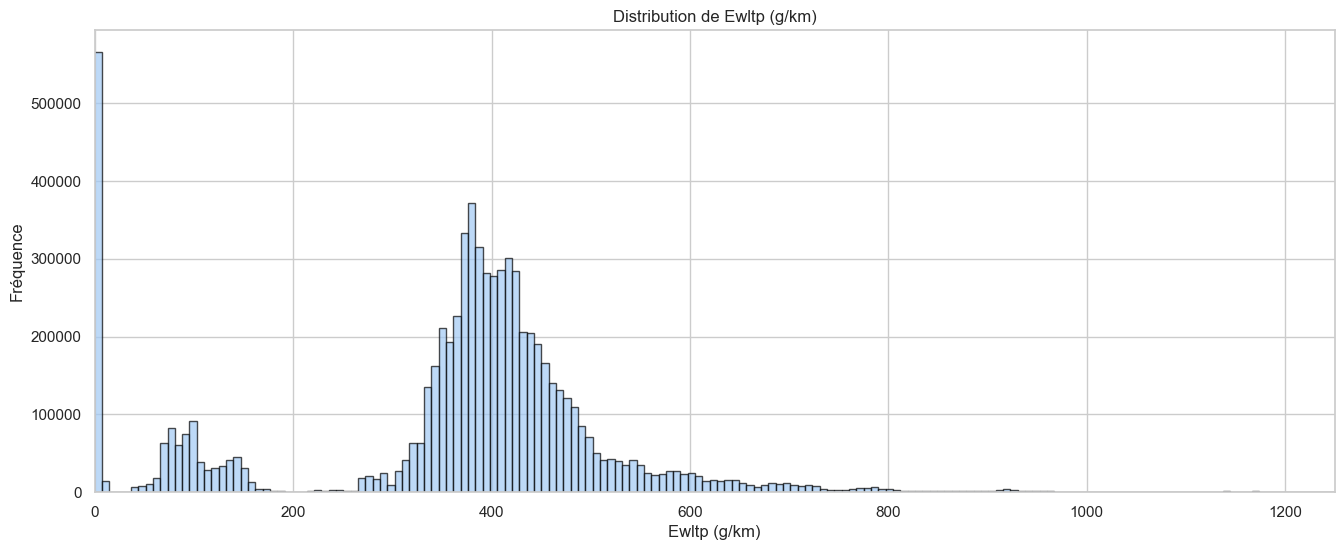

In [17]:
# Distribution de y
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(16, 6))
plt.hist(df_train["Ewltp (g/km)"], bins=300, edgecolor='black', alpha=0.7)

plt.title('Distribution de Ewltp (g/km)')
plt.xlabel('Ewltp (g/km)')
plt.ylabel('Fréquence')

plt.xlim(0, 1250)
plt.show()

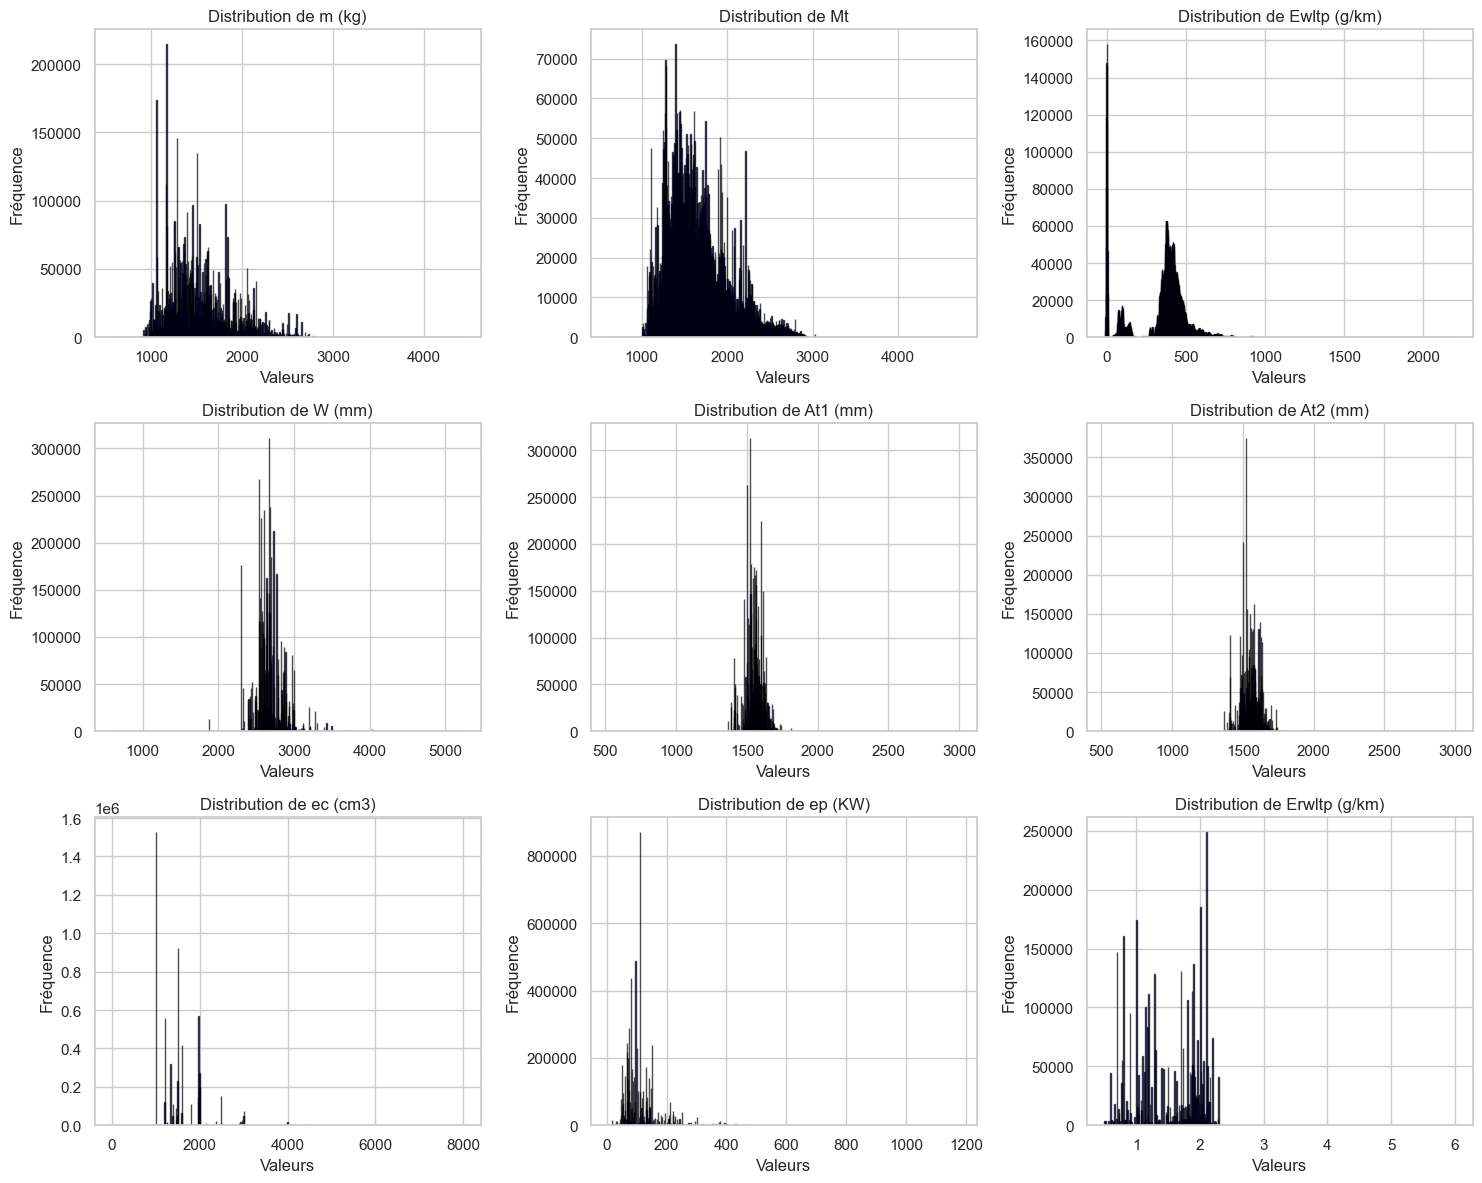

In [18]:
# distribution de quelques variables numériques
prepro.graphs_distributions(['m (kg)', 'Mt', 'Ewltp (g/km)',
                            'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)',
                            'Erwltp (g/km)', 'Fuel consumption'], df_train)

In [19]:
#les variables numériques suivent une distribution normale on peut donc imputer par la med
col_numericals_train_sans_y = [col for col in col_numericals_train if col != 'Ewltp (g/km)']

# Imputation par la médiane
numeric_imputer = SimpleImputer(strategy='median')
df_train[col_numericals_train_sans_y] = numeric_imputer.fit_transform(df_train[col_numericals_train_sans_y])
df_test[col_numericals_test] = numeric_imputer.transform(df_test[col_numericals_test])

# Imputation par le mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_train[col_categoricals_train] = categorical_imputer.fit_transform(df_train[col_categoricals_train])
df_test[col_categoricals_test] = categorical_imputer.transform(df_test[col_categoricals_test])

# Sélection de variables

In [20]:
#avant de drop ID on le stock car on aura besoin pour le fichier final
df_ID_only = df_test["ID"]

## Sélection de variables numériques

<Axes: >

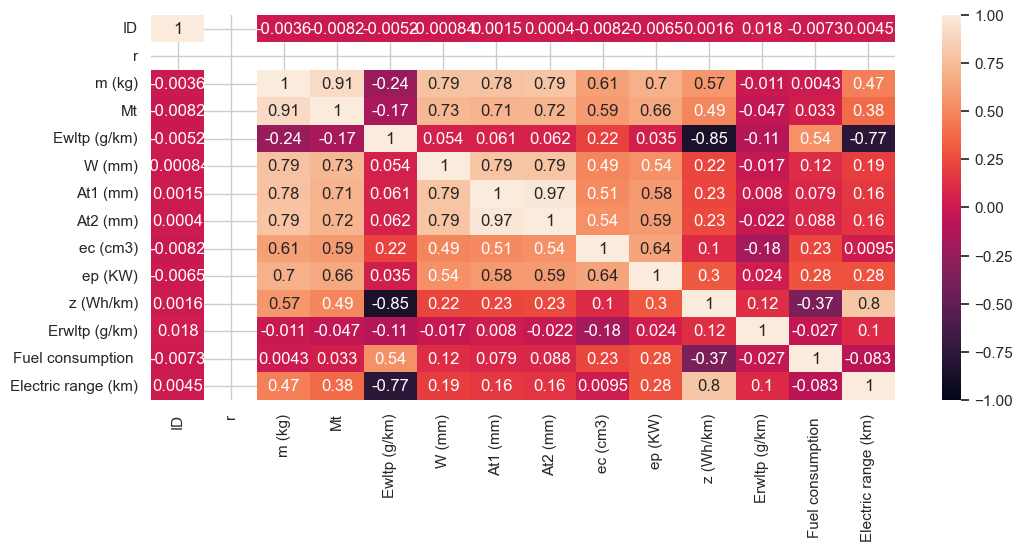

In [21]:
matrice_corr_train = df_train[col_numericals_train].corr()
plt.figure(figsize=(12,5))
sns.heatmap(matrice_corr_train,vmin=-1, vmax=1, annot=True)

In [22]:
# on drop les variables selon la corrélation
variables_to_drop_numeric = ['r', 'At1 (mm)','ID']

df_train = df_train.drop(variables_to_drop_numeric, axis=1)
df_test = df_test.drop(variables_to_drop_numeric, axis=1)

## Sélection de variables catégorielles

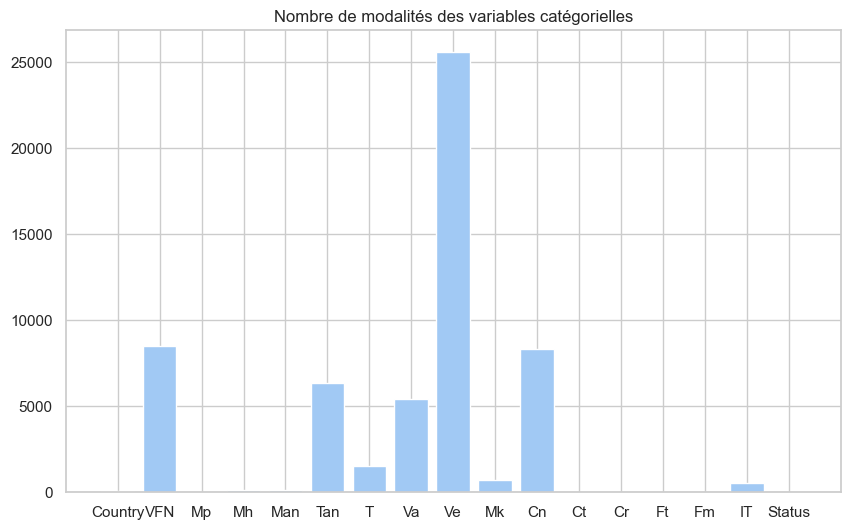

In [23]:
# nombre de modalités des variables catégorielles de df_train
nbre_modalite_col_cat_train = [df_train[col].nunique() for col in col_categoricals_train]

plt.subplots(figsize=(10, 6))
plt.bar(col_categoricals_train, nbre_modalite_col_cat_train)
plt.title("Nombre de modalités des variables catégorielles")
plt.show()

In [24]:
df_train.drop("Status", axis=1, inplace=True)
df_test.drop("Status", axis=1, inplace=True)

In [25]:
# Mettre à jour la liste des variables
col_categoricals_train = df_train.select_dtypes(include='object').columns.tolist()
col_numericals_train = [col for col in df_train.columns if col not in col_categoricals_train]
col_categoricals_test = df_test.select_dtypes(include='object').columns.tolist()
col_numericals_test = [col for col in df_test.columns if col not in col_categoricals_test]

## Encodage

In [26]:
# LabelEncoder
df_train = prepro.encodage(df_train, df_test, col_categoricals_train, col_categoricals_test)[0]
df_test = prepro.encodage(df_train, df_test, col_categoricals_train, col_categoricals_test)[1]

Variable : Country, longueur : 0, modalités différentes : []
Variable : VFN, longueur : 739, modalités différentes : ['IP-0010526-WBA-1', 'AT-5Q0_0v_0211_000-WVW-1', 'IP-MQB27SZ_B2_0441-WVW-1', 'IP-09_1946-5YJ-1', 'IP-13-WAU-2018-2118', 'IP-13-WAU-2018-5042', 'IP-ZKX_REDU7761-VF7-0', 'IP-VN46T1Z_B1_1221-WVN-1', 'IP-0000481-WBA-1', 'IP-2018_1617-WDB-1', 'IP-1040-ZCF-1', 'IP-02_10_2021_3219-W1V-1', 'IP-08_ZAX_0091_00-W0', 'IP-FDC1AMDDW6A_000-VF1-1', 'IP-FBA1A6DTL6A_000-VF1-1', 'IP-13_2019_506-JMZ-1', 'IP-13_2019_507-JMZ-1', 'IP-03_2021_0004-ZAM-1', 'IP-MQB37AZ_A1_1935-WVW-1', 'IP-44JLPHEVSAH-1C4-1', 'IP-0401451-KMH-1', 'IP-YHZ____ATN83143-VF3-5', 'IP-YHZ____ATN83143-VF3-2', 'IP-24-WBA-2018-0003', 'IP-U625_2019_00001-WG0-1', 'IP-0000471-WBA-1', 'IP-2018_4008-WDB-1', 'IP-13-WAU-2018-5010', 'IP-01-WDF-2018-2506', 'IP-ZKX____REDU6761-W0V-0', 'IP-08_ZAA_0001_02-W0V-1', 'IP-FBA1NBPTL4B_000-VF1-1', 'IP-11-SAL-2018-0070', 'IP-YHT____MB6_611D-W0V-', 'IP-MQB27SZ_b0_1043-TMB-1', 'SG5-e11-SDK-2018-0

In [27]:
df_train

,Country,VFN,Mp,Mh,Man,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,m (kg),Mt,Ewltp (g/km),W (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Erwltp (g/km),Fuel consumption,Electric range (km)
0,5,4559,1,33,35,4536,533,4490,1802,180,3565,0,0,1387.0,1534.0,401.053306,2700.0,1576.0,8,3,999.0,92.0,0.0,240,2.30,5.6,0.0
1,10,6825,9,93,101,3617,373,1275,10861,693,6284,0,0,1172.0,1337.0,394.684459,2552.0,1483.0,8,4,999.0,70.0,0.0,209,1.14,5.5,0.0
2,10,6814,9,93,101,3617,373,1275,8766,693,6284,0,0,1204.0,1335.0,398.561951,2552.0,1483.0,8,4,999.0,70.0,0.0,209,1.14,5.6,0.0
3,5,1658,3,48,49,5605,469,1805,6763,360,6343,0,0,1438.0,1588.0,479.470056,2650.0,1563.0,8,4,1591.0,150.0,0.0,357,0.80,6.8,0.0
4,10,6851,9,93,101,3617,373,1273,8773,693,6284,0,0,1207.0,1350.0,421.854820,2552.0,1483.0,8,4,999.0,81.0,0.0,209,1.14,5.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571644,10,6366,9,7,7,3446,760,5392,8360,27,6482,0,0,1815.0,2006.0,481.847421,2829.0,1626.0,0,3,1968.0,120.0,0.0,21,1.68,5.9,0.0
7571645,10,6366,9,7,7,3446,760,5392,8360,27,6482,0,0,1815.0,2028.0,486.397483,2829.0,1626.0,0,3,1968.0,120.0,0.0,21,1.68,5.9,0.0
7571646,10,6366,9,7,7,3446,760,5392,8360,27,6482,0,0,1815.0,2006.0,487.868524,2829.0,1626.0,0,3,1968.0,120.0,0.0,21,1.68,5.9,0.0
7571647,16,6128,6,70,80,5363,919,2413,6536,508,5806,0,0,1240.0,1582.0,350.795221,2525.0,1520.0,5,0,999.0,68.0,0.0,21,0.80,6.2,0.0


In [28]:
df_test

,Country,VFN,Mp,Mh,Man,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,m (kg),Mt,W (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Erwltp (g/km),Fuel consumption,Electric range (km)
0,10,4673,7,76,84,6561,1048,2413,6910,113,1971,0,0,1797.0,1888.0,2785.0,1605.0,9,5,1598.0,132.0,159.0,21,1.68,1.3,59.0
1,14,1484,2,41,41,5834,415,1756,6676,235,8721,0,0,1165.0,1297.0,2580.0,1536.0,8,4,998.0,73.0,0.0,21,1.68,4.7,0.0
2,14,1484,2,41,41,5834,415,1756,6676,235,8721,0,0,1165.0,1297.0,2580.0,1536.0,8,4,998.0,73.0,0.0,21,1.68,4.7,0.0
3,14,1484,2,41,41,5834,415,1756,6676,235,8721,0,0,1165.0,1297.0,2580.0,1536.0,8,4,998.0,73.0,0.0,21,1.68,4.7,0.0
4,14,1484,2,41,41,5834,415,1756,6676,235,8721,0,0,1165.0,1297.0,2580.0,1536.0,8,4,998.0,73.0,0.0,21,1.68,4.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892908,1,5842,6,77,86,5106,1176,3285,16765,549,2034,0,0,1616.0,1698.0,2639.0,1541.0,9,5,1598.0,68.0,133.0,0,1.68,1.3,49.0
1892909,1,3373,5,63,71,3789,673,4343,26735,474,3289,0,0,2040.0,2121.0,2729.0,1611.0,3,1,1498.0,140.0,180.0,0,1.68,5.4,421.0
1892910,1,6248,9,93,101,4026,572,611,22366,694,4362,0,0,2120.0,2260.0,2771.0,1562.0,3,1,1498.0,150.0,174.0,21,1.68,5.4,511.0
1892911,1,1260,9,91,99,6161,1476,4172,17794,632,7774,0,0,1290.0,1412.0,2560.0,1520.0,8,3,1490.0,68.0,0.0,0,1.68,5.0,0.0


<Axes: >

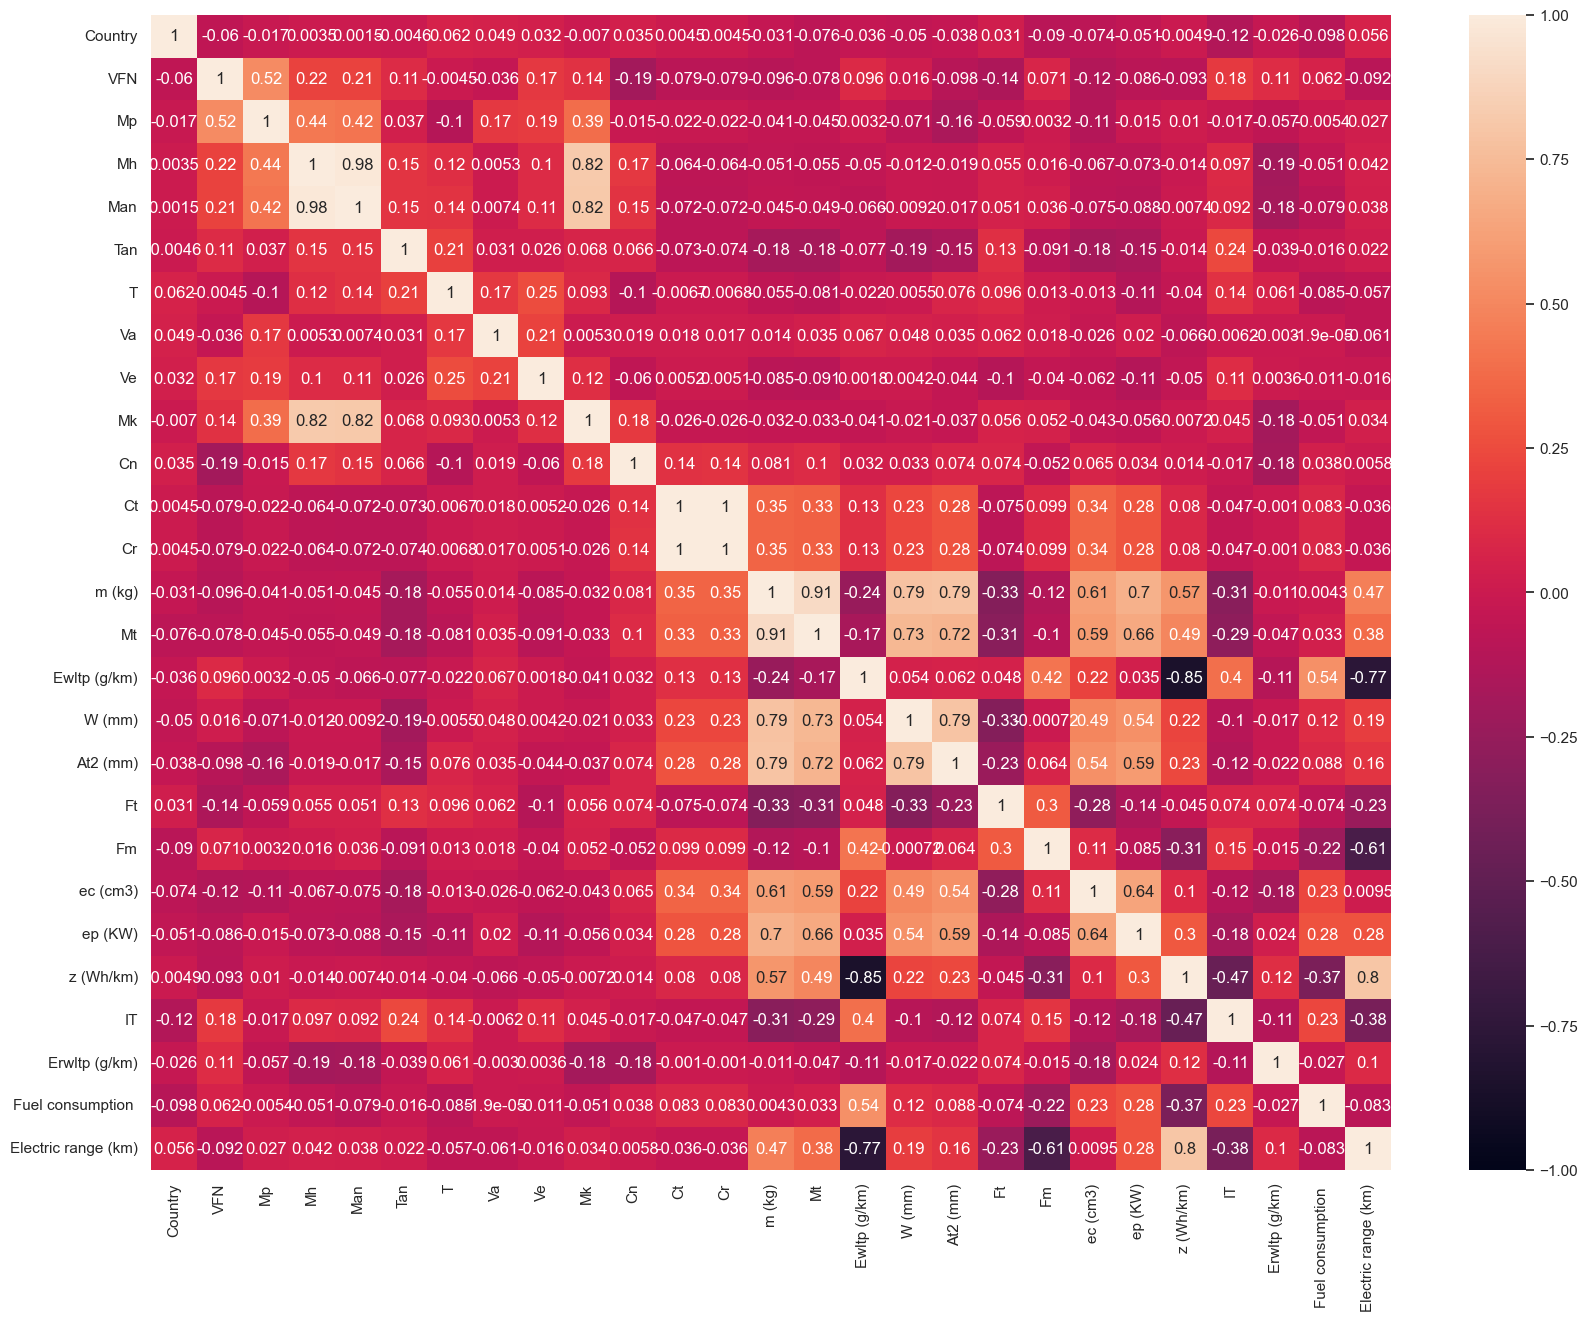

In [29]:
variables_corr = list(df_train.columns)
matrice_corr_train = df_train[variables_corr].corr()

# Afficher un heatmap de la matrice de correlation 
plt.figure(figsize=(20,15))
sns.heatmap(matrice_corr_train,vmin=-1, vmax=1, annot=True)

# Train Test Split

In [26]:
X_train = df_train.drop(['Ewltp (g/km)'], axis=1)  # Caractéristiques (toutes les colonnes sauf la cible)
y_train = df_train['Ewltp (g/km)']  # Cible

# séparer en set de validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = df_test

# Modélisation

In [27]:
# XGBoost + calcul de la MAE sur le set de validation
model = modele.xgboost_prediction(X_train, X_validation, y_train, y_validation)

[0]	train-mae:137.76642	validation-mae:137.99443
[200]	train-mae:50.65996	validation-mae:50.76337
[400]	train-mae:18.80538	validation-mae:18.88565
[600]	train-mae:7.43223	validation-mae:7.53968
[800]	train-mae:3.72503	validation-mae:3.87765
[1000]	train-mae:2.78669	validation-mae:2.97337
[1200]	train-mae:2.62322	validation-mae:2.82342
[1400]	train-mae:2.59753	validation-mae:2.80225
[1600]	train-mae:2.59289	validation-mae:2.79934
[1800]	train-mae:2.59158	validation-mae:2.79893
[1967]	train-mae:2.59087	validation-mae:2.79889
MAE : 2.798887917831921


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

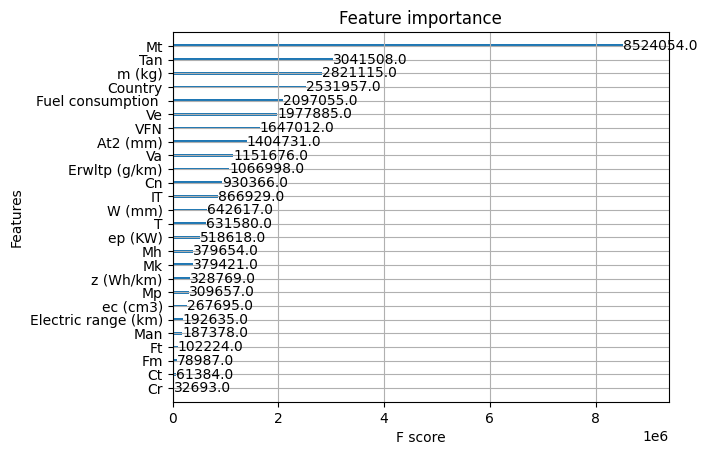

In [28]:
xgb.plot_importance(model)

# Prédiction sur df_test et exportation

In [29]:
# prédiction sur df_test
dtest_reg = xgb.DMatrix(X_test, enable_categorical=True)
y_test_pred = model.predict(dtest_reg)
len(y_test_pred)

1892913

In [31]:
new_df = pd.concat([pd.DataFrame(df_ID_only), pd.DataFrame(y_test_pred)], axis=1)
new_df.rename(columns={0 :'Ewltp (g/km)'}, inplace=True)
new_df['ID'] = new_df['ID'].astype(int)

In [32]:
new_df

,ID,Ewltp (g/km)
0,8000000,94.293549
1,8000001,385.677460
2,8000002,385.677460
3,8000003,385.677460
4,8000004,385.677460
...,...,...
1892908,9892908,93.945816
1892909,9892909,0.027587
1892910,9892910,0.103684
1892911,9892911,354.582275


In [33]:
# exportation
new_df.to_csv('LabelEncoder_XGB_TTS_2_7988.csv', index=False)